# Notebook Outline

1. Loading statements from Nitin and Edgar 

1. Combining statements from Nitin and Edgar

1. Selecting unique and non-NA statements

1. Extracting year from statement

1. Text processing and cleaning  
  
    * uk to us conversion, for ex. organisation -> organization
    * extracting and removing urls from text
    * removing sentences with words "privacy", "cookies"
    * removing stopwords, special characters
    * fixing word contractions, for ex. they'll -> they will
    * removing company name from the statement - company name in the statement is not relevant for textual analysis
    * lemmatization (lemmatize automatically using NLTK POS tagger)
    * filtering words with word-size between 2 and 15
    
1. Generating similarity score between statements and removing 99% duplicate statements

1. Finding a threshold length to check whether a statement is modern slavery statement or scrap statement

In [1]:
# use if autocompletion is not working
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
from os import getcwd
import numpy as np
from tqdm import tqdm
import re
from typing import Tuple, Dict, Sequence, List, Union
from copy import deepcopy
from urlextract import URLExtract
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from spacy import load

import nltk
from nltk.corpus import wordnet

In [4]:
from modern_slavery_registry import text_parser, utils

In [5]:
PROJECT_PATH = getcwd()
PROJECT_PATH = PROJECT_PATH.replace("\\notebooks", "")
DATA_PATH = PROJECT_PATH +  "\\data"
SHEETS_PATH = DATA_PATH + "\\sheets"
RANDOM_STATE = 42

## Loading modern slavery statements from Edgar and Nitin

In [6]:
prof_data = pd.read_json(f"{SHEETS_PATH}\\modern_slavery_dataset_prof.json")
cols_to_keep = ["Company ID", "Company", "Statement ID", "URL", "Text"]
prof_data.drop_duplicates(inplace=True)
prof_data.dropna(subset=["Company ID"], inplace=True)
prof_data.reset_index(drop=True, inplace=True)
prof_data = prof_data[cols_to_keep]
cols_type = ["int32", str, float, str, str]
for i, col in enumerate(prof_data.columns):
    prof_data[col] = prof_data[col].astype(cols_type[i])
prof_data.rename(columns = {"Text": "statement(Edgar)"},  
                 inplace = True) 



my_data = pd.read_excel(f"{SHEETS_PATH}\\modern_slavery_dataset_nitin.xlsx")
cols_to_keep = ["Company ID", "Company", "Statement ID", "URL", "statement"]
my_data.drop_duplicates(inplace=True)
my_data.dropna(subset=["Company ID"], inplace=True)
my_data.reset_index(drop=True, inplace=True)
my_data = my_data[cols_to_keep]
for i, col in enumerate(my_data.columns):
    my_data[col] = my_data[col].astype(cols_type[i])
my_data.rename(columns = {"statement": "statement(Nitin)"},  
               inplace = True)

print(f"Total statements (non-NA and NA) Edgar: {len(prof_data)}, Nitin: {len(my_data)} ")

Total statements (non-NA and NA) Edgar: 28361, Nitin: 27527 


In [7]:
prof_data.head(3)

,Company ID,Company,Statement ID,URL,statement(Edgar)
0,7676,"""K"" Line Holding Europe Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
2,28659,"""K"" Line (Europe) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...


In [8]:
my_data.head(3)

,Company ID,Company,Statement ID,URL,statement(Nitin)
0,7676,"""K"" Line Holding Europe Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,66 99 “K” Line Holding (Europe) Limited kM K L...
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,66 99 “K” Line Holding (Europe) Limited kM K L...
2,28659,"""K"" Line (Europe) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,66 99 “K” Line Holding (Europe) Limited kM K L...


## Combining both datasets 

In [9]:
combine_data = pd.merge(prof_data,
                        my_data,
                        on = ["Company ID", "Company", "Statement ID", "URL"], 
                        how = "outer")
combine_data.drop_duplicates(inplace=True)
combine_data.reset_index(drop=True, inplace=True)
combine_data.fillna("#NA", inplace=True)
combine_data["statement(Edgar)"] = ["#NA" if text in ("nan", "None") or text == "" else text for text in combine_data["statement(Edgar)"]]
combine_data["statement(Nitin)"] = ["#NA" if text in ("nan", "None") or text == "" else text for text in combine_data["statement(Nitin)"]]

PRIMARY = "Nitin"
if PRIMARY == "Nitin":
    secondary = "Edgar"
    primary_code = "N"
    secondary_code = "E"
else:
    secondary = "Nitin"
    primary_code = "E"
    secondary_code = "N"
    
    
statements = [
    (primary_code, combine_data[f"statement({PRIMARY})"].iloc[i]) if combine_data[f"statement({PRIMARY})"].iloc[i] != "#NA" else 
    (secondary_code, combine_data[f"statement({secondary})"].iloc[i]) for i in range(len(combine_data))
]

choice = [_[0] for _ in statements]
statements = [_[1] for _ in statements]
combine_data["final_statement"] = statements
combine_data["final_statement(E/N)"] = choice

In [10]:
combine_data.head()

,Company ID,Company,Statement ID,URL,statement(Edgar),statement(Nitin),final_statement,final_statement(E/N)
0,7676,"""K"" Line Holding Europe Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N
2,28659,"""K"" Line (Europe) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N
3,28661,"""K"" Line LNG Shipping Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N
4,28658,Polar LNG Shipping (UK) Limited,35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N


In [11]:
print("Before cleaning")
print(f"Total final statements: {len(combine_data)}")
print(f"Total NA final_statements: {np.sum((combine_data['final_statement'] == '#NA'))}")
print(f"Total non-NA final_statements: {np.sum((combine_data['final_statement'] != '#NA'))}")
print("Total non-NA final_statements(E): "
      f"{np.sum((combine_data['final_statement'] != '#NA') & (combine_data['final_statement(E/N)'] == 'E'))}")
print("Total non-NA final_statements(N): "
      f"{np.sum((combine_data['final_statement'] != '#NA') & (combine_data['final_statement(E/N)'] == 'N'))}")

Before cleaning
Total final statements: 28364
Total NA final_statements: 7663
Total non-NA final_statements: 20701
Total non-NA final_statements(E): 2365
Total non-NA final_statements(N): 18336


## Selecting unique statements

In [12]:
subset_data = combine_data[
    combine_data["final_statement"]!="#NA"][["URL", "Company", "final_statement"]].copy()
subset_data.drop_duplicates(subset="URL", inplace=True)
subset_data.head()

,URL,Company,final_statement
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...


In [13]:
print(f"Unique non-NA statements in subset data: {len(subset_data)}")

Unique non-NA statements in subset data: 11969


In [14]:
n_sentences = len(subset_data)

## Extracting year from statement

Using regular expression for this: an approximate to find year can be 4 digit number where first digit can between 1 and 2 all inclusive and last 3 digits can be between 0 and 9 all inclusive.

In [15]:
def extract_year(text: str) -> List[str]:
    text = text.split(".")
    years = []
    for sentence in text: 
        years += re.findall(r"\b[2][0-9]{3}\b", sentence)
    return list(set(years))

def extract_year_with_act_in_statement(text: str) -> List[str]:
    text = text.split(".")
    years = []
    for sentence in text:
        if len(re.findall(r"\bact\b", sentence.lower())) > 0:
               years += re.findall(r"\b[2][0-9]{3}\b", sentence)
    return list(set(years))

In [16]:
print(f"All years: {extract_year('modern slavery act act 2019 2018. This is not an year: 12343434. This is: 2012, but not year for statement.')}")
print(f"All years with act in statement: {extract_year_with_act_in_statement('modern slavery act act 2019 2018. This is not an year: 12343434. This is: 2012, but not year for statement.')}")

All years: ['2012', '2019', '2018']
All years with act in statement: ['2019', '2018']


In [17]:
subset_data["years_with_and_without_act"] = [
    extract_year(statement) for statement in tqdm(subset_data["final_statement"].values)]

subset_data["years_with_act"] = [
    extract_year_with_act_in_statement(statement) for statement in tqdm(subset_data["final_statement"].values)]

100%|██████████████████████████████████████████████████████████████████████████| 11969/11969 [00:06<00:00, 1959.56it/s]


In [18]:
subset_data.head()

,URL,Company,final_statement,years_with_and_without_act,years_with_act
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...,"[2015, 2019, 2018]","[2015, 2019]"
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...,[2015],[2015]
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...,"[2015, 2019, 2018]","[2015, 2018]"
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...,"[2015, 2019, 2018]","[2015, 2018]"
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...,"[2015, 2019, 2018]","[2015, 2018]"


## Text Cleaning and Preprocessing

UK-to-US word mappings

In [19]:
uk_to_us_mappings = pd.read_excel(f"{DATA_PATH}\\UK_to_US_word_mappings.xlsx")
uk_to_us_mappings = {row[0]: row[1] for row in  uk_to_us_mappings.values}

url_extractor = URLExtract()

In [20]:
def clean_text(text: str):
    text = text.lower()
    text = text.replace("\n"," ")
    text = text.replace("\t"," ")
    
    urls = url_extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, " ")
    
    remove_tokens = [
        ["privacy", "policy"],
        "cookies",
        "skip content",
        "please donate",
        "signup",
        "download",
        "newsletter"]
    text = text_parser.remove_sentences_with_tokens(text, tokens=remove_tokens)
    
    text = text_parser.replace_special_chars(
        text, replace_digits=False)
    
    text = text_parser.remove_stopwords(text)
    
    words_in_text = []
    for word in text.split():
        word = text_parser.word_expantions[word] if word in text_parser.word_expantions else word
        word = uk_to_us_mappings[word] if word in uk_to_us_mappings else word
        words_in_text.append(word)
    
    text = " ".join(words_in_text)
    
    # additional filtering and removing phrases
    remove_phrases = [
#         "uk modern slavery act statement",
#         "uk modern slavery act",
#         "california transparency supply chain act statement",
#         "california transparency supply chain act",
        "modern slavery act statement",
        "modern slavery act",
        "transparency supply chain act statement", 
        "transparency supply chain act",
        "modern slavery statement",
        "modern slavery act",
        "modern slavery", 
        "modern day slavery statement", 
        "modern day slavery", 
        "slavery", 
        "human trafficking statement",
        "policy statement"]
   
    for phrases in remove_phrases:
        text = text.replace(phrases, "")
        
    return " ".join(text.split())

In [21]:
subset_data["final_statement_cleaned"] = [
    clean_text(statement) for statement in tqdm(subset_data["final_statement"].values, position=0, leave=True)]
subset_data = subset_data[subset_data["final_statement_cleaned"] != ""]
print(f"Unique non-NA cleaned statements in subset data: {len(subset_data)}")

100%|████████████████████████████████████████████████████████████████████████████| 11969/11969 [17:43<00:00, 11.25it/s]

Unique non-NA cleaned statements in subset data: 11917


In [22]:
subset_data["company_cleaned"] = [
    clean_text(company) for company in tqdm(subset_data["Company"], position=0, leave=True)]

100%|██████████████████████████████████████████████████████████████████████████| 11917/11917 [00:04<00:00, 2797.06it/s]


In [23]:
subset_data.head()

,URL,Company,final_statement,years_with_and_without_act,years_with_act,final_statement_cleaned,company_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...,"[2015, 2019, 2018]","[2015, 2019]",66 99 k line holding europe limited km k line ...,k line holding europe limited
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...,[2015],[2015],1spatial home solutions solutions government b...,1spatial plc
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...,"[2015, 2019, 2018]","[2015, 2018]",shazans shazan foods continues monitor covid 1...,1stop halal limited
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...,"[2015, 2019, 2018]","[2015, 2018]",7 28 2019 2018 1st step solutions 1 6 e r n l ...,1st step solutions limited
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...,"[2015, 2019, 2018]","[2015, 2018]",fh 2015 introduction uk 2015 act requires busi...,2 agriculture limited


In [24]:
NGRAMS=(1,4)
ngrams_from_corpus = text_parser.generate_ngrams(
    subset_data["final_statement_cleaned"].values, 
    ngrams=NGRAMS)

100%|███████████████████████████████████████████████████████████████████████████| 11917/11917 [00:14<00:00, 822.53it/s]


In [25]:
term_freq, doc_freq = text_parser.compute_term_doc_freq(
    ngrams_from_corpus=ngrams_from_corpus, 
    sort=True, 
    descending=True)

11917it [00:34, 347.53it/s]


In [26]:
MAX = 20
popular_ngrams = {n: {"count": 0, "ngrams": []} for n in range(NGRAMS[0], NGRAMS[-1]+1)}
sum_count = 0 
for i, (k,v) in enumerate(term_freq.items()):
    if sum([popular_ngrams[n]["count"] for n in popular_ngrams.keys()]) == MAX*NGRAMS[-1]:
        break
    n = len(k.split())
    if popular_ngrams[n]["count"] < MAX:
        popular_ngrams[n]["ngrams"].append((k, v))
        popular_ngrams[n]["count"]+=1

In [27]:
popular_ngrams

{1: {'count': 20,
  'ngrams': [('human', 89751),
   ('supply', 85133),
   ('business', 80592),
   ('suppliers', 72750),
   ('trafficking', 66129),
   ('risk', 46975),
   ('chain', 45353),
   ('group', 42754),
   ('policy', 39044),
   ('supplier', 35449),
   ('chains', 35158),
   ('uk', 34927),
   ('labor', 34003),
   ('employees', 33834),
   ('company', 31414),
   ('ensure', 31070),
   ('services', 30852),
   ('rights', 29933),
   ('statement', 29193),
   ('code', 28307)]},
 2: {'count': 20,
  'ngrams': [('human trafficking', 62615),
   ('supply chain', 43959),
   ('supply chains', 34916),
   ('human rights', 22933),
   ('code conduct', 15572),
   ('due diligence', 14814),
   ('business supply', 12491),
   ('financial year', 10535),
   ('forced labor', 8338),
   ('taking place', 7483),
   ('third party', 6905),
   ('section 54', 6700),
   ('supplier code', 5945),
   ('statement made', 5509),
   ('within business', 5474),
   ('zero tolerance', 5445),
   ('risk human', 5419),
   ('ensure

Removing company name from the company

In [28]:
del ngrams_from_corpus, term_freq, doc_freq

In [29]:
def remove_company_name(company_name: str, 
                        statement: str) -> str:
    """Remove company name instances present in the statement."""
    mappings = text_parser.find_ngrams_in_text(sentence=company_name,
                                   text=statement)
    # to remove big text first
    mappings = {k:v for k,v in sorted(mappings.items(), key=lambda x:x[1])} 
    for ngram, cnt in mappings.items():
        if cnt > 0:
            ngram_splitted = ngram.split()
            # to skip unigram of length 1 and single character in unigram
            if not (len(ngram_splitted) == 1 and len(ngram_splitted[0]) == 1): 
                statement = statement.replace(ngram," ")

    statement = " ".join(statement.split())
    return statement

In [30]:
subset_data["final_statement_cleaned"] = [remove_company_name(company_name=row[0], 
                                                              statement=row[1]) 
                                          for row in tqdm(subset_data[["company_cleaned",
                                                                       "final_statement_cleaned"]].values,
                                                          position=0, 
                                                          leave=True)]
subset_data = subset_data[subset_data["final_statement_cleaned"] != ""]
subset_data.drop("company_cleaned", axis=1, inplace=True)
subset_data.head()

100%|██████████████████████████████████████████████████████████████████████████| 11917/11917 [00:09<00:00, 1310.61it/s]


,URL,Company,final_statement,years_with_and_without_act,years_with_act,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...,"[2015, 2019, 2018]","[2015, 2019]",66 99 km sh foor eum holding europe ltd 200 al...
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...,[2015],[2015],home solutions solutions government boundaries...
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...,"[2015, 2019, 2018]","[2015, 2018]",shazans shazan foods continues monitor covid 1...
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...,"[2015, 2019, 2018]","[2015, 2018]",7 28 2019 2018 1 6 e r n l v e r e e n 2 0 1 8...
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...,"[2015, 2019, 2018]","[2015, 2018]",fh 2015 introduction uk 2015 act requires busi...


In [31]:
print(f"Unique non-NA cleaned statements in subset data: {len(subset_data)}")

Unique non-NA cleaned statements in subset data: 11917


Lemmatizing

In [32]:
# https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258
# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
    
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = {x[0]:nltk_tag_to_wordnet_tag(x[1]) for x in nltk_tagged}
    lemmatized_sentence = []
    for word, tag in wordnet_tagged.items():
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [33]:
cleaned_statements = [
    lemmatize_sentence(sentence=statement) for statement in tqdm(
        subset_data["final_statement_cleaned"], position=0, leave=True)]

100%|████████████████████████████████████████████████████████████████████████████| 11917/11917 [10:13<00:00, 19.43it/s]


## Analying single word sizes

In [34]:
word_sizes = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if size not in word_sizes:
            word_sizes[size] = 1
        else:
            word_sizes[size] += 1
word_sizes = utils.sort_dict(word_sizes, by=0)
print(f"Total distinct word sizes: {len(word_sizes)}")

100%|██████████████████████████████████████████████████████████████████████████| 11917/11917 [00:02<00:00, 5413.77it/s]

Total distinct word sizes: 106


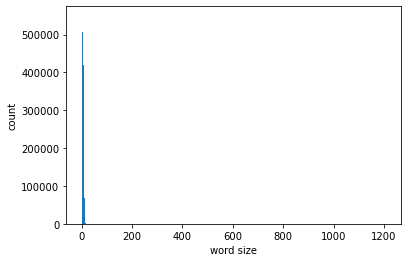

In [35]:
fig, ax = plt.subplots()
ax.bar(word_sizes.keys(), word_sizes.values())
ax.set_xlabel("word size")
ax.set_ylabel("count")
plt.show()

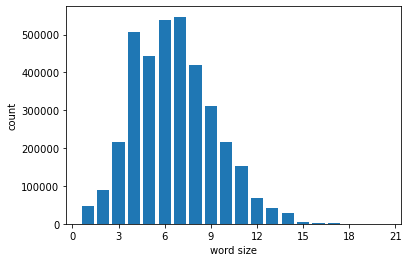

In [36]:
fig, ax = plt.subplots()
upper_limit = 20
ax.bar(list(word_sizes.keys())[:upper_limit], list(word_sizes.values())[:upper_limit])
ax.set_xlabel("word size")
ax.set_ylabel("count")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

From above plot, it seems like max word size can be restricted to 15 and min word size to 2

In [37]:
MIN_WORD_SIZE = 2
MAX_WORD_SIZE = 15
temp_cleaned_statements = []
for statement in tqdm(cleaned_statements, position=0, leave=True):
    temp_cleaned_statements.append(
        " ".join([word for word in statement.split() 
                  if MIN_WORD_SIZE <= len(word) <= MAX_WORD_SIZE]))
cleaned_statements = deepcopy(temp_cleaned_statements)
del temp_cleaned_statements

100%|█████████████████████████████████████████████████████████████████████████| 11917/11917 [00:01<00:00, 10427.36it/s]


In [38]:
subset_data

,URL,Company,final_statement,years_with_and_without_act,years_with_act,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...,"[2015, 2019, 2018]","[2015, 2019]",66 99 km sh foor eum holding europe ltd 200 al...
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...,[2015],[2015],home solutions solutions government boundaries...
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...,"[2015, 2019, 2018]","[2015, 2018]",shazans shazan foods continues monitor covid 1...
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...,"[2015, 2019, 2018]","[2015, 2018]",7 28 2019 2018 1 6 e r n l v e r e e n 2 0 1 8...
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...,"[2015, 2019, 2018]","[2015, 2018]",fh 2015 introduction uk 2015 act requires busi...
...,...,...,...,...,...,...
27521,https://wndirect.com/download_file/view_inline...,wnDirect Limited,(Cwnwect wnDirect Slavery and Human Traffickin...,"[2015, 2016]","[2015, 2016]",cwnwect 2016 introduction stuart hill ceo find...
27522,https://www.your-move.co.uk/help/modern-slavery,your-move.co.uk Limited,Modern Slavery We use cookies to provide the b...,"[2019, 2017, 2020, 2006, 2016, 2015, 2018]","[2015, 2006, 2019, 2018]",manage preferences banner via browser anytime ...
28361,https://nilehq.com/modern-slavery-statement/,Nile HQ Limited,Modern Slavery Statement | Nile Skip to conten...,"[2015, 2020]",[2015],skip content main menu helpmenu toggle helphow...
28362,https://www.princesgroup.com/wp-content/upload...,Princes Limited,MODERN SLAVERY ACT STATEMENT for the Financial...,"[2019, 2030, 2017, 2020, 2023, 2015, 2018]","[2015, 2020]",financial year ended 31 march 2020 statement d...


In [39]:
subset_data.dtypes

URL                           object
Company                       object
final_statement               object
years_with_and_without_act    object
years_with_act                object
final_statement_cleaned       object
dtype: object

In [41]:
subset_data["final_statement_cleaned"] = cleaned_statements
subset_data = subset_data[subset_data["final_statement_cleaned"] != ""]
# list unhashable, avoid while using drop duplicate command
subset_data.drop_duplicates(subset_data.columns.difference(["years_with_and_without_act", "years_with_act"]), inplace=True)
subset_data.head()

,URL,Company,final_statement,years_with_and_without_act,years_with_act,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...,"[2015, 2019, 2018]","[2015, 2019]",66 99 km sh foor eum hold europe ltd 200 alder...
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...,[2015],[2015],home solution government boundary law enforcem...
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...,"[2015, 2019, 2018]","[2015, 2018]",shazans shazan food continue monitor covid 19 ...
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...,"[2015, 2019, 2018]","[2015, 2018]",28 2019 2018 statement make pursuant sec 54 20...
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...,"[2015, 2019, 2018]","[2015, 2018]",fh 2015 introduction uk act require business s...


In [42]:
print(f"Unique non-NA cleaned statements in subset data: {len(subset_data)}")

Unique non-NA cleaned statements in subset data: 11917


## Generating similarity score (positional similarity) between statements and removing 98% duplicate statements

In [43]:
N_GRAM = (1, 1)
count_vect = CountVectorizer(ngram_range=N_GRAM)
X = count_vect.fit_transform(subset_data["final_statement_cleaned"])
print(f"Count vector shape: {X.shape}")

Count vector shape: (11917, 87074)


In [44]:
similarity_matrix = cosine_similarity(X, X)

In [45]:
DUPLICATE_SIMILARITY_SCORE_THRESHOLD = .98
n = X.shape[0]
dup_mapping = {} 
dup_idxs = []
for idx in tqdm(range(n), position=0, leave=True):
    if idx not in dup_idxs:
        idxs = np.argwhere(similarity_matrix[idx][idx+1:] > DUPLICATE_SIMILARITY_SCORE_THRESHOLD).ravel()
        if len(idxs) > 0:
            idxs += idx+1 # shifting
            dup_mapping[idx] = idxs
            dup_idxs += list(idxs)
dup_mapping = {subset_data.index[k]:[subset_data.index[idx] for idx in v] for k,v in dup_mapping.items()}
dup_idxs = [subset_data.index[idx] for idx in dup_idxs]

100%|██████████████████████████████████████████████████████████████████████████| 11917/11917 [00:02<00:00, 4595.84it/s]


In [46]:
print(f"Found {len(np.unique(dup_idxs))} out of {len(subset_data)} with {DUPLICATE_SIMILARITY_SCORE_THRESHOLD*100}% duplicacy")

Found 1126 out of 11917 with 98.0% duplicacy


In [47]:
i = 0
orig, dups = list(dup_mapping.items())[i]
print(f"orig:  url: {subset_data['URL'].loc[orig]} \nstatement: {subset_data['final_statement_cleaned'].loc[orig][:500]}\n")
for j, k in enumerate(dups):
    print(f"dup-{j}: url: {subset_data['URL'].loc[k]} \nstatement: {subset_data['final_statement_cleaned'].loc[k][:500]}\n")
    

orig:  url: https://cdn.shopify.com/s/files/1/1217/7686/t/2/assets/Modern-slavery-and-human-trafficking-statement.pdf?98 
statement: page date 01 apr 19 document sect2 policy27 issue date 04 version revise allcorn authorize newcombe barber cheesemakers group aj rg ltd ditcheat somerset ba4 6pr ford farm ashley chase estate litton cheney dorset dt2 9az introduction statement set action understand potential risk relate business put place step aim ensure human traffic supply chain relate activity financial year april 2019 31 march 2020 part uk dairy industry organization recognize responsibility take robust approach absolutely c

dup-0: url: https://cdn.shopify.com/s/files/1/1217/7686/t/2/assets/Modern-slavery-and-human-trafficking-statement.pdf?10982987683653637190 
statement: page date 01 apr 19 document sect2 policy27 issue date 04 version revise allcorn authorize newcombe barber cheesemakers group aj rg ltd ditcheat somerset ba4 6pr ford farm ashley chase estate litton cheney dorset d

In [48]:
subset_data.drop(dup_idxs, axis=0, inplace=True)
print(f"Unique non-NA cleaned statements in subset data: {len(subset_data)}")

Unique non-NA cleaned statements in subset data: 10791


## Finding a threshold length to validate that a statement is modern slavery statement or scrap text

In [49]:
subset_data["len(final_statement_cleaned)"] = subset_data["final_statement_cleaned"].apply(lambda x: len(x))

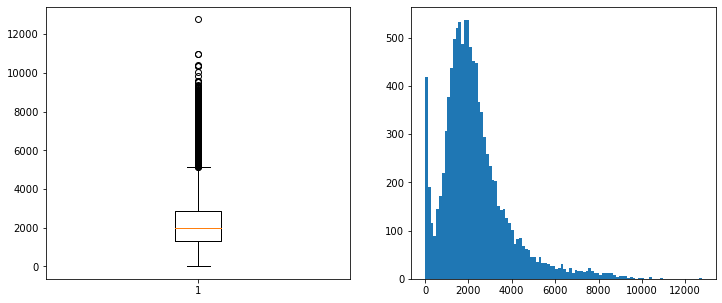

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.boxplot(subset_data["len(final_statement_cleaned)"])
ax2.hist(subset_data["len(final_statement_cleaned)"], bins=100)
plt.show()

In [51]:
THRESHOLD_WORD_COUNT = 500
scrap_data = subset_data[subset_data["len(final_statement_cleaned)"] < THRESHOLD_WORD_COUNT]
scrap_data.head()

,URL,Company,final_statement,years_with_and_without_act,years_with_act,final_statement_cleaned,len(final_statement_cleaned)
17,http://www.2020projects.co.uk/modernslaverypolicy,20/20 Projects,"Contact\n< class=""entry-title"">Not found, erro...",[],[],contact class entry title find error 404 page ...,130
80,https://www.aschulman.com/regulatory/californi...,A. Schulman Inc.,"Page Not Found\nUnfortunately, we could not fi...",[],[],page find unfortunately could find look please...,122
85,https://www.agbarr.co.uk/modern-slavery-statem...,A.G. BARR plc,"International\nPage not found!\nSorry, the pag...",[],[],international page find sorry look can not mig...,105
129,http://abmna.com/ctscad/,AB Mauri Food Inc.,Back Home\nABOUT US\nAB Mauri® North America i...,[],[],back home us mauri north america division glob...,226
142,https://www.abcsupply.com/help/ca-supply-chain...,"ABC Supply Co, Inc.",CA Supply Chain Transparency Act Skip to main ...,[2020],[2020],buy substantially product sale north american ...,266


In [52]:
np.random.seed(RANDOM_STATE)
for i in np.random.choice(scrap_data.index, replace=False, size=5):
    print(f"{i}: {scrap_data['final_statement_cleaned'].loc[i][:100]}")
    print(f"{'-'*100}")

24447: sorry page try view exist look like result either mistyped address use search box site
----------------------------------------------------------------------------------------------------
23357: submit search
----------------------------------------------------------------------------------------------------
3109: right reserve partner 2020 fine site hide message
----------------------------------------------------------------------------------------------------
18974: uh oh lose track shopping please select confirm inventory ready delivery zip code enter would like u
----------------------------------------------------------------------------------------------------
3141: enter register email address click send reset password follow link see sec
----------------------------------------------------------------------------------------------------


In [53]:
print(f"Found {len(scrap_data)} scrap statements out of {len(subset_data)} modern slavery statements with {THRESHOLD_WORD_COUNT} threshold word count")

Found 798 scrap statements out of 10791 modern slavery statements with 500 threshold word count


In [54]:
subset_data = subset_data[subset_data["len(final_statement_cleaned)"] >= THRESHOLD_WORD_COUNT]
print(f"Unique non-NA, cleaned and filtered statements in subset data: {len(subset_data)}")

Unique non-NA, cleaned and filtered statements in subset data: 9993


In [55]:
subset_data.to_excel(f"{SHEETS_PATH}\\subset_data.xlsx", engine='xlsxwriter', index=False)